In [14]:
import ROOT
import numpy as np
#from root_numpy import random_sample
from scipy.ndimage import uniform_filter
import time
import matplotlib.pyplot as plt
import multiprocessing as mp

<h1>Simulation Model</h1>


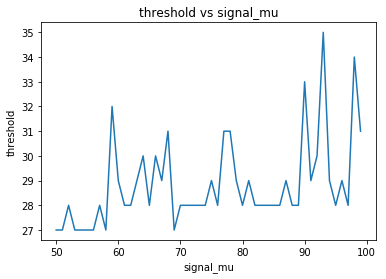

/usr/lib64/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Simulation took 136.4 seconds


In [60]:
# the constants of the constants. Pretty much choose once and leave it. Do not change.
C_total_channels = int(3.6 * 1e6)
C_channels_per_module = int(15*30)
C_total_modules = int(C_total_channels/C_channels_per_module)

# skip
#C_max_radius = 1

### Skipping radius dependency for now...

### Distrubution functions:

   # none written...


#==============================================================================

### Code for the simulation:

def get_number_above_threshold(threshold, count, list_):
    """Counts the number of elements above the threshold in the list"""
    arr = np.fromiter(list_, dtype=np.float, count=count)
    above_count = (arr > threshold).sum()
    return above_count

def sample_random_signals(prng, signal_mu, signal_sigma, signal_count):
    """Samples randomly from the Landau distrubution"""
    return [ prng.Landau(signal_mu, signal_sigma) for _ in range(signal_count) ]

def sample_random_noise(prng, noise_sigma, noise_count):
    """Samples randomly from the Gaus distrubution"""
    return [ prng.Gaus(0, noise_sigma) for _ in range(noise_count) ]

def get_number_of_readouts(ratio_of_channels_to_sample):
    """Returns the number of channels to read from - used to downscale simulation"""
    return int(C_total_channels * ratio_of_channels_to_sample)

def get_noise_count_fast(prng, threshold, noise_sigma, n_channels):
    """Ohms fast noise count.  (I assume n_channels is the number of chanels we try, i.e. noise_reads_per_BC)"""
    p_noise = get_expected_ratio_of_noise_above_threshold(threshold, noise_sigma) # probability mass
    n_noise = p_noise*n_channels # average noise
    noise_count = get_noise_count_fast_cached(n_noise)
    return noise_count
def calculate_variable_n_noise(threshold, noise_sigma, n_channels):
    """Calculates the n_noise in the fast noise count method."""
    p_noise = get_expected_ratio_of_noise_above_threshold(threshold, noise_sigma) # probability mass
    n_noise = p_noise*n_channels # average noise
    return n_noise
def get_noise_count_fast_cached(prng, n_noise):
    """Ohms fast noise count.  But we provide the n_noise directly. See above how to calculate it."""
    noise_count = prng.Poisson(n_noise)
    # But what if it is always below 0.5 then it will ALWAYS be zero, and that is a problem.
    # In that case lets sample whether a channel will be active or not.
    if noise_count < 0.5:
        noise_count = (1 if (prng.Rndm() < noise_count) else 0)
    else:
        noise_count = round(noise_count)
    return noise_count
    

def simulation_get_counts(prng, number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma):
    """Runs a simulation over specified number of BC, and returns two lists:
        signal and noise counts above threshold for each BC"""
    # simulated
    # number of channels that gets to read either signal or noise
    #  We ignore the distrubution and assume average over all BC.
    
    result_signal_count = np.zeros(number_of_BC)
    result_noise_count = np.zeros(number_of_BC)
    
    readouts = get_number_of_readouts(ratio_of_channels_to_sample)
    signal_reads_per_BC = readouts * signal_to_total_event_ratio
    
    # signal reads may not be a whole number, and that is a problem we need to handle.
    # (actually this could happen to noise as well, but we don't handle that)
    if signal_reads_per_BC < 0.5:
        # signal_reads is a fraction:
        probability = signal_reads_per_BC        
        # run each BC
        for BC in range(number_of_BC):
            signal_reads_per_BC = (1 if (prng.Rndm() < probability) else 0)
            noise_reads_per_BC = readouts - signal_reads_per_BC
            n_noise = calculate_variable_n_noise(threshold, noise_sigma, noise_reads_per_BC)
            
            signal_samples = sample_random_signals(prng, signal_mu, signal_sigma, signal_reads_per_BC)
            signal_above_count = get_number_above_threshold(threshold, signal_reads_per_BC, signal_samples)
            result_signal_count[BC] = signal_above_count
            # fast method:  using the cached n_noise
            result_noise_count[BC] = get_noise_count_fast_cached(prng, n_noise)
    else:
        # signal_reads is a whole number:
        signal_reads_per_BC = int(round(signal_reads_per_BC))
        noise_reads_per_BC = readouts - signal_reads_per_BC

        # fast method,  cache n_noise variable
        n_noise = calculate_variable_n_noise(threshold, noise_sigma, noise_reads_per_BC)

        # run each BC
        for BC in range(number_of_BC):
            signal_samples = sample_random_signals(prng, signal_mu, signal_sigma, signal_reads_per_BC)
            #noise_samples = sample_random_noise(prng, noise_sigma, noise_reads_per_BC)

            signal_above_count = get_number_above_threshold(threshold, signal_reads_per_BC, signal_samples)
            #noise_above_count = get_number_above_threshold(threshold, noise_reads_per_BC, noise_samples)

            result_signal_count[BC] = signal_above_count
            #result_noise_count[BC] = noise_above_count
            # fast method:  using the cached n_noise
            result_noise_count[BC] = get_noise_count_fast_cached(prng, n_noise)
    
    return np.asarray([result_signal_count, result_noise_count])

def simulation_get_counts_noise_only(prng, number_of_BC, ratio_of_channels_to_sample, threshold, noise_sigma):
    """Simulation of the large time frame.
        (( HOWEVER: in reality large time fram also contains signal which is not simulated, I don't know... ))"""
    ###  TEMPORARY IMPLEMENTATION,  this one is not accurate!!!
    ###  This one completely ignores signals.
    
    readouts = get_number_of_readouts(ratio_of_channels_to_sample)
    noise_reads_per_BC = readouts   # Every read is a noise.
    
    result_noise_count = np.zeros(number_of_BC)
    
    # run each BC
    for BC in range(number_of_BC):
        noise_samples = sample_random_noise(prng, noise_sigma, noise_reads_per_BC)
        noise_above_count = get_number_above_threshold(threshold, noise_reads_per_BC, noise_samples)
        result_noise_count[BC] = noise_above_count
    
    return result_noise_count

def simulation_parallel_get_counts(number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma):
    """Runs the simulations in parallel inorder to faster simulate. It then combines each result.
        and returns two lists: signal and noise counts above threshold for each BC"""
    global global_counter
    #Simulate
    # parameters
    global_counter += 1  # some variable to make sure we get different seeds
    seed = 123*global_counter
    bins_of_BC = eq_div(number_of_BC, nprocs)
    param_list = [(ROOT.TRandom3(seed + i), int(bins_of_BC[i]), ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma) \
                     for i in range(nprocs)]
    # parallel
    results = np.asarray(pool.starmap(simulation_get_counts, param_list))
    results = np.hstack(results).squeeze() # reshape
    
    signal_count_array = results[0]
    noise_count_array = results[1]
    
    # list of count,  count for each bunch crossing event
    return signal_count_array, noise_count_array


def get_expected_ratio_of_signal_above_threshold(threshold, signal_mu, signal_sigma):
    """Returns the expected ratio of:  signal_above_threshold / total_signal
        Uses integration of the distribution for different intervals to determine expected ratio"""
    low = -200
    high = 500
    
    # expected ratios
    fSignal = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)" % (signal_mu, signal_sigma), low, high)
    fSignal.SetNpx(1000)

    expected_signal_above_to_total_signal_ratio = 1 - fSignal.Integral(low, threshold)/fSignal.Integral(low, high)
    return expected_signal_above_to_total_signal_ratio

def get_expected_ratio_of_noise_above_threshold(threshold, noise_sigma):
    """Returns the expected ratio of:  noise_above_threshold / total_noise
        Uses integration of the distribution for different intervals to determine expected ratio"""
    low = -200
    high = 500
    
    # expected ratios
    fNoise = ROOT.TF1("ElecNoiseBg", "TMath::Gaus(x, 0, %f)" % noise_sigma, low, high)
    fNoise.SetNpx(1000)

    expected_noise_above_to_total_noise_ratio = 1 - fNoise.Integral(low, threshold)/fNoise.Integral(low, high)
    return expected_noise_above_to_total_noise_ratio

def get_listed_deviation_from_expected(list_signal, list_noise, number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma):
    """Get the deviation from the simulated signals vs the expected signals as a list for each BC.
        Returns the deviation for each BC as a list of positive numbers"""
    
    # expected ratios
    expected_noise_above_to_total_noise_ratio = get_expected_ratio_of_noise_above_threshold(threshold, noise_sigma)
    expected_signal_above_to_total_signal_ratio = get_expected_ratio_of_signal_above_threshold(threshold, signal_mu, signal_sigma)
    
    # calculate how many channels where used, and signal, noise for channels
    readouts = get_number_of_readouts(ratio_of_channels_to_sample)
    signal_reads_per_BC = int(round(readouts * signal_to_total_event_ratio))
    
    # I DON'T KNOW HOW TO HANDLE <1 READS PER BC
    if signal_reads_per_BC < 1:
        signal_reads_per_BC = readouts * signal_to_total_event_ratio
    
    #noise_reads_per_BC = readouts - signal_reads_per_BC
    #total_signal_count = signal_reads_per_BC * number_of_BC
    #total_noise_count = noise_reads_per_BC * number_of_BC
    
    scale_threshold_to_total = 1 / (signal_to_total_event_ratio*expected_signal_above_to_total_signal_ratio                     \
                                    + (1-signal_to_total_event_ratio)*expected_noise_above_to_total_noise_ratio)

    # list_signal, list_noise contains the true number of events for each bunch crossing
    
    # this is a value we get from the detector
    simulated_above_count_for_BC = list_signal + list_noise
    #computed_total_count_for_BC = simulated_above_count_for_BC * scale_threshold_to_total
    #computed_total_signal_count_for_BC = computed_total_count_for_BC * signal_to_total_event_ratio
    #deviation_list = (np.abs(1 - computed_total_signal_count_for_BC / signal_reads_per_BC))
    # ALTERNATIVE
    deviation_list = (abs(1 - simulated_above_count_for_BC / expected_signal_above_to_total_signal_ratio / signal_reads_per_BC))
    
    return deviation_list
    
def get_total_deviation_from_expected(list_signal, list_noise, number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma):
    """Get the total deviation from the total simulated signals vs the expected signals.
        Returns both the total deviation as a positive number"""
    low = -200
    high = 500
    
    # expected ratios
    expected_noise_above_to_total_noise_ratio = get_expected_ratio_of_noise_above_threshold(threshold, noise_sigma)
    expected_signal_above_to_total_signal_ratio = get_expected_ratio_of_signal_above_threshold(threshold, signal_mu, signal_sigma)
    
    # calculate how many channels where used, and signal, noise for channels
    readouts = get_number_of_readouts(ratio_of_channels_to_sample)
    signal_reads_per_BC = int(round(readouts * signal_to_total_event_ratio))
    
    # I DON'T KNOW HOW TO HANDLE <1 READS PER BC
    if signal_reads_per_BC < 1:
        signal_reads_per_BC = readouts * signal_to_total_event_ratio
        
    noise_reads_per_BC = readouts - signal_reads_per_BC
    total_signal_count = signal_reads_per_BC * number_of_BC
    total_noise_count = noise_reads_per_BC * number_of_BC
    
    scale_threshold_to_total = 1 / (signal_to_total_event_ratio*expected_signal_above_to_total_signal_ratio                     \
                                    + (1-signal_to_total_event_ratio)*expected_noise_above_to_total_noise_ratio)

    # list_signal, list_noise contains the true number of events for each bunch crossing
    
    # this is a value we get from the detector
    simulated_total_above_count = list_signal.sum() + list_noise.sum()
    #computed_total_count = simulated_total_above_count * scale_threshold_to_total
    #computed_total_signal_count = computed_total_count * signal_to_total_event_ratio
    #total_deviation = (abs(1 - computed_total_signal_count / total_signal_count))
    # ALTERNATIVE
    total_deviation = (abs(1 - simulated_total_above_count / expected_signal_above_to_total_signal_ratio / total_signal_count))
    
    return total_deviation

def get_total_deviation_from_expected_with_simulated_results(number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma):
    """Small helper method to pipe the simulation results into the deviation calculation directly."""
    simulation_signal_count_result, simulation_noise_count_result = simulation_parallel_get_counts(number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma)
    return get_total_deviation_from_expected(simulation_signal_count_result, simulation_noise_count_result, number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, threshold, signal_mu, signal_sigma, noise_sigma)
    

def get_the_best_threshold_and_deviation_in_terms_of_least_deviation(list_of_thresholds_to_try, number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, signal_mu, signal_sigma, noise_sigma):
    """Simulates for each threshold provided in list, tests which threshold has the least deviation in computed vs expected.
        and returns the best threshold it has found, also returns the deviation."""
    list_of_thresholds_to_try = list(list_of_thresholds_to_try) # enforce list
    deviation_iter = ([
        get_total_deviation_from_expected_with_simulated_results(
            number_of_BC,
            ratio_of_channels_to_sample,
            signal_to_total_event_ratio,
            threshold,
            signal_mu,
            signal_sigma,
            noise_sigma)
        for threshold in list_of_thresholds_to_try])
    deviations = np.fromiter(deviation_iter, dtype=np.float, count=len(list_of_thresholds_to_try))
    
    # Blur the deviations,  assumes deviations follow a smooth curve.
    # The actuall minimum should not be discarded because of a random deviation, therefore blur.
    size = 5  # default is 3,  might want to change to 3
    deviations_blur = uniform_filter(deviations, size=size)#[1:-1] # nah no need to slice, the boundary error doesn't bother us
    
    # get the minimum
    index = np.argmin(deviations_blur)
    threshold = list_of_thresholds_to_try[index]
    deviation = deviations[index]
    
    return threshold, deviation

def get_the_best_threshold_in_terms_of_least_deviation(list_of_thresholds_to_try, number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, signal_mu, signal_sigma, noise_sigma):
    """Same as above, except it only returns the threshold"""
    threshold, deviation = get_the_best_threshold_and_deviation_in_terms_of_least_deviation(list_of_thresholds_to_try, number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, signal_mu, signal_sigma, noise_sigma)
    return threshold


def caluclate_SB(expected_signal_voltage, noise_sigma):
    """Formula for calculating S/B"""
    return expected_signal_voltage / noise_sigma

def calculate_expected_signal_voltage(signal_mu, signal_sigma):
    """Some method to calculate the expected signal voltage for provided signal_mu and sigma"""
    
    # INTEGRATION METHOD:  (not used)
        # Use the definition:  ∫(x*f(x))dx
    """
        low = 0  # There are no particles hitting the detector with negative energies.
        high = 500
        fSignalEnergy = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)*x" % (signal_mu, signal_sigma), low, high)
        scale = 1  # 0.001  # mili, no sigma is also in mV so it doesn't matter
        return fSignalEnergy.Integral(low, high) * charge * scale
    """
    # ASSUME MU IS THE EXPECTED VALUE:  (currently used)
    return signal_mu

def calculate_list_of_SB_from_list_of_signal_mu(noise_sigma, iterator_mu, steps):
    """Returns a list of calculated S/B for a list of signal mu."""
    return np.fromiter(
                map(lambda signal_mu : caluclate_SB(
                        calculate_expected_signal_voltage(signal_mu, get_signal_sigma_for_mu(signal_mu)),
                        noise_sigma) ,
                    iterator_mu)
             , dtype=np.float, count=steps)

def compute_list_of_least_deviation_from_list_of_signal_mu(number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, noise_sigma, linspace_data_thresholds, linspace_data_signal_mu, number_of_mu_steps):
    """It will try a lot of thresholds provided for each signal_mu provided,
        and get the best result from the threasholds and put that least deviation result in a list for each signal mu."""
    return np.fromiter(
                 map(lambda signal_mu :
                         get_the_best_threshold_and_deviation_in_terms_of_least_deviation(
                             linspace(*linspace_data_thresholds),  # list_of_thresholds_to_try
                             number_of_BC,
                             ratio_of_channels_to_sample,
                             signal_to_total_event_ratio,
                             signal_mu,
                             get_signal_sigma_for_mu(signal_mu),
                             noise_sigma)[1] ,  # deviation is at index 1
                         linspace(*linspace_data_signal_mu))
                 , dtype=np.float, count=number_of_mu_steps)

def compute_list_of_best_thresholds_from_list_of_signal_mu(number_of_BC, ratio_of_channels_to_sample, signal_to_total_event_ratio, noise_sigma, linspace_data_thresholds, linspace_data_signal_mu, number_of_mu_steps):
    """It will try a lot of thresholds provided for each signal_mu provided,
        and get the best result threasholds from the least deviation,
        and put that threasholds in a list for each signal mu."""
    return np.fromiter(
                 map(lambda signal_mu :
                         get_the_best_threshold_in_terms_of_least_deviation(
                             linspace(*linspace_data_thresholds),  # list_of_thresholds_to_try
                             number_of_BC,
                             ratio_of_channels_to_sample,
                             signal_to_total_event_ratio,
                             signal_mu,
                             get_signal_sigma_for_mu(signal_mu),
                             noise_sigma) ,  
                         linspace(*linspace_data_signal_mu))
                 , dtype=np.float, count=number_of_mu_steps)



# -End of simulation code-

#==============================================================================

### Code for the plots:

def plot_deviation_vs_SB():
    """Plots deviation vs S/B. See settings below to calibrate the simulation"""
    # Simulator Settings:
        # expected time:  [BC: cpu*3  AND  1.0 ]:  50s
        # expected time:  [BC: cpu*3  AND  0.01]:  10s
    ratio_of_channels_to_sample = 1.0  # scale of simulation,   0.001 = small fast,   1.0 = full scale slow.
    number_of_BC = mp.cpu_count() * 16
    
    signal_to_total_event_ratio = get_signal_to_total_event_ratio()
    noise_sigma = 5  #mv
    
    min_signal_mu = 15  #mv  # cannot be below 0
    max_signal_mu = 40 #mv
    steps_signal_mu = (max_signal_mu - min_signal_mu) * 1   # resolution
    
    min_threshold = 2  #mv  # cannot be below 0
    max_threshold = 50 #mv
    steps_threshold = (max_threshold - min_threshold) * 1   # resolution

    
    #signal_mu_list = list(linspace(min_signal_mu, max_signal_mu, steps_signal_mu)) # can be used to plot
    SB = calculate_list_of_SB_from_list_of_signal_mu(
            noise_sigma,
            linspace(min_signal_mu, max_signal_mu, steps_signal_mu),
            steps_signal_mu
        )
    
    linspace_data_signal_mu = (min_signal_mu, max_signal_mu, steps_signal_mu)
    linspace_data_thresholds = (min_threshold, max_threshold, steps_threshold)
    deviations = compute_list_of_least_deviation_from_list_of_signal_mu(
            number_of_BC,
            ratio_of_channels_to_sample,
            signal_to_total_event_ratio,
            noise_sigma,
            linspace_data_thresholds,
            linspace_data_signal_mu, 
            steps_signal_mu
        )
    
    #deviations_log = np.log(deviations)
    
    # plot
    x_list = SB
    y_list = deviations
    title = "Deviations vs SNR"
    prefix_filename = "Deviations_vs_SB_with_BC" + str(number_of_BC)
    xlabel = "SNR"
    ylabel = "Deviations"
    make_integer_axis = False
    make_margin = False
    plot_the_data(title, prefix_filename, xlabel, ylabel, make_integer_axis, make_margin, x_list, y_list)
    

def plot3D_threshold_and_SB_vs_deviation():
    """Creates a 3D plot of threshold and S/B vs deviaiton"""
    # Simulator Settings:
    ratio_of_channels_to_sample = 0.01  # scale of simulation,   0.001 = small fast,   1.0 = full scale slow.
    number_of_BC = mp.cpu_count() * 1
    
    signal_to_total_event_ratio = get_signal_to_total_event_ratio()
    noise_sigma = 5  #mv
    
    min_signal_mu = 15  #mv  # cannot be below 0
    max_signal_mu = 40 #mv
    steps_signal_mu = (max_signal_mu - min_signal_mu) * 1   # resolution
    
    min_threshold = 2  #mv  # cannot be below 0
    max_threshold = 50 #mv
    steps_threshold = (max_threshold - min_threshold) * 1   # resolution

    canvas = ROOT.TCanvas("c","Graph2D example",0,0,600,400)
    plot_threshold_SB_deviation = ROOT.TGraph2D()
    point_index = 0
    for loop_signal_mu in linspace(min_signal_mu, max_signal_mu, steps_signal_mu):
        for loop_treshold in linspace(min_threshold, max_threshold, steps_threshold):
            
            signal_sigma = get_signal_sigma_for_mu(loop_signal_mu)
            
            deviation = get_total_deviation_from_expected_with_simulated_results(
                            number_of_BC,
                            ratio_of_channels_to_sample,
                            signal_to_total_event_ratio,
                            loop_treshold,
                            loop_signal_mu,
                            signal_sigma,
                            noise_sigma
                        )
            SB = caluclate_SB(calculate_expected_signal_voltage(loop_signal_mu, signal_sigma), noise_sigma)
            
            plot_threshold_SB_deviation.SetPoint(point_index, SB, loop_treshold, deviation) # i, x, y, z
            point_index += 1
    
    
    plot_threshold_SB_deviation.SetTitle("Graph title; X axis title; Y axis title; Z axis title");
    plot_threshold_SB_deviation.Draw("surf1")
    canvas.Draw()
    print("done")

    
def plot_particle_intensity_mu_vs_best_threshold():    
    # Simulator Settings
    ratio_of_channels_to_sample = 1.0  # scale of simulation,   0.001 = small fast,   1.0 = full scale slow.
    number_of_BC = mp.cpu_count() * 8
    
    noise_sigma = 5  #mv
    signal_mu = 50 # mv  # might want to change this
    signal_sigma = get_signal_sigma_for_mu(signal_mu)
    
    min_threshold = 2  #mv  # cannot be below 0
    max_threshold = 80 #mv
    steps_threshold = (max_threshold - min_threshold) * 1   # resolution
    
    # important setting for this simulation
    min_intensity_mu = 0.008
    max_intensity_mu = 0.015
    steps_intensity_mu = (15-8)*3
    
    intensity_mu_list = list(linspace(min_intensity_mu, max_intensity_mu, steps_intensity_mu))
    threshold_list = [None]*len(intensity_mu_list)
    
    for index, collisions_per_BC in enumerate(intensity_mu_list):
        signal_to_total_event_ratio = get_signal_to_total_event_ratio(collisions_per_BC=collisions_per_BC)
        
        threshold, deviation = get_the_best_threshold_and_deviation_in_terms_of_least_deviation(
                        linspace(min_threshold, max_threshold, steps_threshold), #list_of_thresholds_to_try,
                        number_of_BC,
                        ratio_of_channels_to_sample,
                        signal_to_total_event_ratio,
                        signal_mu,
                        signal_sigma,
                        noise_sigma
                    )
        threshold_list[index] = threshold
    
    # print result in list form
    print(threshold_list)
    
    # plot
    x_list = intensity_mu_list
    y_list = threshold_list
    title = "threshold vs intensity_mu"
    prefix_filename = "threshold_vs_intensity_mu_with_BC" + str(number_of_BC)
    xlabel = "intensity_mu"
    ylabel = "threshold"
    make_integer_axis = True
    make_margin = False
    plot_the_data(title, prefix_filename, xlabel, ylabel, make_integer_axis, make_margin, x_list, y_list)
    

def plot_signal_mu_vs_best_threshold():
    # Simulator Settings
    ratio_of_channels_to_sample = 1.0  # scale of simulation,   0.001 = small fast,   1.0 = full scale slow.
    number_of_BC = mp.cpu_count() * 4
    
    signal_to_total_event_ratio = get_signal_to_total_event_ratio()
    
    noise_sigma = 5  #mv
    
    min_threshold = 2  #mv  # cannot be below 0
    max_threshold = 80 #mv
    steps_threshold = (max_threshold - min_threshold) * 1   # resolution
    
    min_signal_mu = 50  #mv  # cannot be below 0
    max_signal_mu = 100 #mv
    steps_signal_mu = 50   # resolution
    
    linspace_data_thresholds = (min_threshold, max_threshold, steps_threshold)
    linspace_data_signal_mu = (min_signal_mu, max_signal_mu, steps_signal_mu)
    
    signal_mu_list = list(linspace(*linspace_data_signal_mu))
    
    threshold_list = compute_list_of_best_thresholds_from_list_of_signal_mu(
        number_of_BC,
        ratio_of_channels_to_sample,
        signal_to_total_event_ratio,
        noise_sigma,
        linspace_data_thresholds,
        linspace_data_signal_mu,
        steps_signal_mu
    )
    
    # plot
    x_list = signal_mu_list
    y_list = threshold_list
    title = "threshold vs signal_mu"
    prefix_filename = "threshold_vs_signal_mu_with_BC" + str(number_of_BC)
    xlabel = "signal_mu"
    ylabel = "threshold"
    make_integer_axis = False
    make_margin = False
    plot_the_data(title, prefix_filename, xlabel, ylabel, make_integer_axis, make_margin, x_list, y_list)


def plot_the_data(title, prefix_filename, xlabel, ylabel, make_integer_axis, make_margin, x_list, y_list):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    FILENAME = prefix_filename + "_(" + timestr + ").pdf"
    
    fig = plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if make_integer_axis:
        plt.locator_params(axis="both", integer=True) # integer axis
    if make_margin:
        plt.margins(y=1)  # add margin to y
    
    plt.plot(x_list, y_list)
    plt.show()
    ax = fig.add_subplot(111)
    fig.savefig(FILENAME)
    #fig.savefig(FILENAME, dpi=200)  # use for png
    

    
# -End of plot code-
    
#==============================================================================

### Helper functions:

def eq_div(N, i):
    return [N // i + 1] * (N % i) + [N // i] * (i - N % i)
def np_stats(np_list):
    """Use a list from e.g. simulaiton_combined_get_counts and get statistics about that list"""
    return np.mean(np_list), np.var(np_list), np.std(np_list)
def print_count_statistics(np_list):
    """Use a list from e.g. simulaiton_combined_get_counts and get statistics about that list"""
    mean, variance, standard_deviation = np_stats(np_list)
    print("mean:", mean)
    print("variance:", variance)
    print("standard_deviation:", standard_deviation)
def get_signal_sigma_for_mu(signal_mu):
    reference_singal_mu = 100  # from s.15  (at threshold 40)
    reference_signal_sigma = 25  #mv  25 from reference for signal_mu = 100 (s.24)
    minimum = 0.01
    signal_sigma = minimum + reference_signal_sigma * (signal_mu/reference_singal_mu) 
    return signal_sigma
def get_signal_to_total_event_ratio(collisions_per_BC = 50, particles_per_collision = 500, ratio_of_particles_reaching_HGTD=0.1):
    #collisions_per_BC = 50
    #particles_per_collision = 500
    #ratio_of_particles_reaching_HGTD = 0.1
    signal_to_total_event_ratio = collisions_per_BC * particles_per_collision * ratio_of_particles_reaching_HGTD / C_total_channels
    return signal_to_total_event_ratio
def linspace(start, end, steps):
    scale = (end-start)/(steps)
    return map(lambda x : start + x*scale, range(steps)) # does not include the last value, since steps = length


# -End of helper functions-

#==============================================================================

###  Main code - what to run, what to plot, what do calculate

def main():
    # code... what to plot, what do calculate, ...
    
    #plot_deviation_vs_SB()
    #plot3D_threshold_and_SB_vs_deviation()
    #plot_particle_intensity_mu_vs_best_threshold()
    #plot_signal_mu_vs_best_threshold()
    
    
    # -code end-


    
    
### Not important to understand ... it's just a startup script, see main() above instead.
if __name__ == '__main__':
    mp.freeze_support()
    
    # profiles to determine compute resources
    profiles = {"normal": 2, "fast": 4, "fastest": 99}
    max_processes = profiles["fastest"]  # edit this
    
    # setup pool
    nprocs = min(mp.cpu_count(), max_processes)
    pool = mp.Pool(processes=nprocs)
    
    global_counter = 0
    
    # run code
    t0 = time.time()
    main()
    t1 = time.time()
    print("Simulation took", round(t1-t0, 1), "seconds")
    
    # clean up
    pool.close()
    pool.join()



====================================================


<h1>Testing</h1>


In [82]:
low = -200
high = 500
noise_sigma = 5
threshold = 10

# expected ratios
fNoise = ROOT.TF1("ElecNoiseBg", "TMath::Gaus(x, 0, %f)" % noise_sigma, low, high)
fNoise.SetNpx(1000)

expected_noise_above_to_total_noise_ratio = 1 - fNoise.Integral(low, threshold)/fNoise.Integral(low, high)
print(expected_noise_above_to_total_noise_ratio)
print(fNoise.Integral(low, threshold))
print(fNoise.Integral(low, high))
# wtf

0.022750131948179764
12.24801075319054
12.533141373155008


# Notes

Fast noise metoder verkar under estimata deviation med typ 0.001, inte för det spelar någon roll dock...